In [46]:
import matplotlib.pyplot as plt
# import libraries
import mne
import pathlib
import pandas as pd
import numpy as np
from gtda.time_series import SingleTakensEmbedding
from sklearn.decomposition import PCA
from gtda.homology import VietorisRipsPersistence
import argparse
from gtda.diagrams import BettiCurve, PersistenceEntropy, Amplitude

In [47]:

# Define parameters
epoch_length = 60  # in seconds
overlap = 30  # in seconds (1 ms)
# time between the start of consecutive epochs
event_interval = epoch_length - overlap
# Generate fake events
sfreq = 256  # sampling frequency
event_duration = int(sfreq * epoch_length)  # number of samples in an epoch
# number of samples between consecutive events
event_step = int(sfreq * event_interval)
n_events = int((153344 - event_duration) / event_step) + 1
events = np.array([[int(i * event_step), 0, 1] for i in range(n_events)])
frequencies = np.arange(8, 30, 1)  # Frequencies of interest from 8 to 30 Hz
n_cycles = frequencies / 2.  # Number of cycles in Morlet wavelet
groupName = ['HTR','CTR','VIP','SNY']
groups = ['0','1','2','3']

In [66]:
def compute_tda(types,group_idx,file_idx):
    data_dir = pathlib.Path(f"./data/raw/{types}/")
    rawPath = []
    files = list(data_dir.glob(f"*{groups[group_idx]}_raw.fif"))
    rawPath = sorted(files)
    rawPath = rawPath[file_idx-1:file_idx]
    # create epochs
    raw = mne.io.read_raw_fif(rawPath[0], preload=True)
    epochs = mne.Epochs(raw, events, event_id=1, tmin=0,tmax=epoch_length, baseline=None, preload=True)
    num_epochs = len(epochs)
    print("num_epochs : ", num_epochs)
    data = epochs.get_data(copy=True)
    # create objects
    embedding_dimension = 10
    embedding_time_delay = 50
    stride = 10
    embedder = SingleTakensEmbedding(
        parameters_type="search", n_jobs=48, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
    )
    pca = PCA(n_components=3)
    vr = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=48)
    for epoch_idx in range(num_epochs):
        for electrode_idx in range(64):
            embeddings = embedder.fit_transform(data[epoch_idx,electrode_idx,:])# taken's theorem
            # print('Optimal time delay based on mutual information:',embedder.time_delay_)
            # print('Optimal embedding dimension based on false nearest neighbors:',embedder.dimension_)
            # print('Optimal embedding stride:',embedder.stride)
            point_cloud = pca.fit_transform(embeddings) # convert to 3 dim point cloud
            diagram = vr.fit_transform([point_cloud])
            np.save(f"./data/48plots/electode_ft/features/sub{file_idx}_electode{electrode_idx}_{epoch_idx}.png", diagram)


In [67]:
compute_tda("think2", 0 ,1)

Opening raw data file data/raw/think2/file0_0_raw.fif...
Isotrak not found
    Range : 0 ... 153343 =      0.000 ...   598.996 secs
Ready.
Reading 0 ... 153343  =      0.000 ...   598.996 secs...
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 15361 original time points ...
0 bad epochs dropped
num_epochs :  18


In [26]:
pEntropy = np.zeros((3,18), dtype=np.float64)
p = PersistenceEntropy()
for file_idx in range(18):
    arr = np.load(f"./data/48plots/electode_ft/features/sub1/electode1_{file_idx}.png.npy")
    pe = p.fit_transform(arr)
    for i in range(3):
        pEntropy[i][file_idx] = pe[0][i]

In [32]:
amplitude = np.zeros((3,18), dtype=np.float64)
ampObject = Amplitude()
for file_idx in range(18):
    arr = np.load(f"./data/48plots/electode_ft/features/sub1/electode1_{file_idx}.png.npy")
    aa = ampObject.fit_transform(arr)
    for i in range(3):
        amplitude[i][file_idx] = aa[0][i]

In [34]:
areas = np.zeros((3,18), dtype=np.float64)
betti = BettiCurve()
for file_idx in range(18):
    arr = np.load(f"./data/48plots/electode_ft/features/sub1/electode1_{file_idx}.png.npy")
    curve = betti.fit_transform(arr)
    radii = np.linspace(0, 1, curve.shape[2])
    for i in range(3):
        areas[i][file_idx] = np.trapz(curve[0][i], radii)

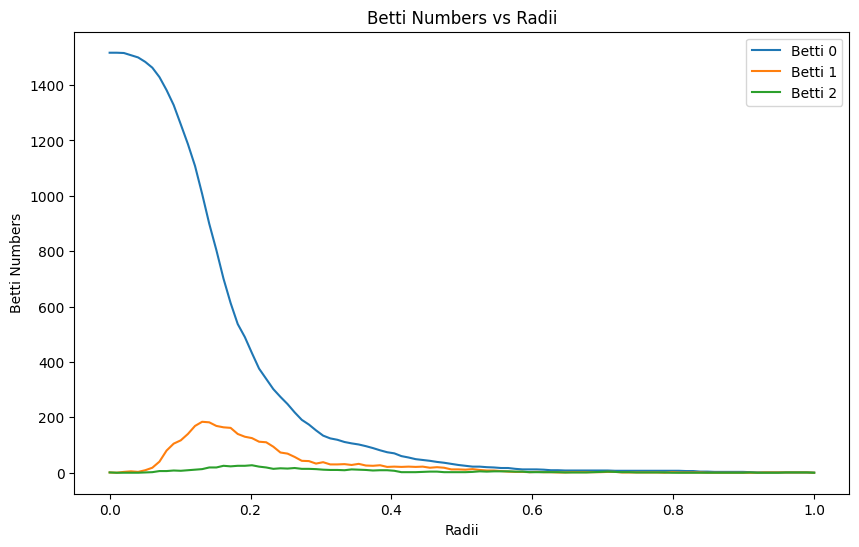

In [42]:
# Generate a sequence of radii
radii = np.linspace(0, 1, len(curve[0][0]))
# Plot Betti curves
plt.figure(figsize=(10, 6))
plt.plot(radii, curve[0][0], label='Betti 0')
plt.plot(radii, curve[0][1], label='Betti 1')
plt.plot(radii, curve[0][2], label='Betti 2')
plt.xlabel('Radii')
plt.ylabel('Betti Numbers')
plt.title('Betti Numbers vs Radii')
plt.legend()
# plt.savefig("./images/1.png")
plt.show()#